# Mathematical modeling of ambient barcodes

Jupyter notebook containing analysis to model ambient barcode spread in real cells/nucei vs. empty droplets.

Input for this notebook requires:
1) A csv file with all captured cell barcodes from the raw matrix for the no g dataset
2) The raw gene expression matrix from the no g dataset
3) RVdG barcode count matrices from the no g dataset

Output for this notebook includes:
1) Bayesian analysis of probability of a cell passing an RVdG barcode UMI threshold across gene and RVdG UMI counts
2) Plots modeling unique barcode distribution and total UMIs across all droplets

Module and their versions used when generating figures for the paper can be found in 'empty_droplet_modeling_requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was developed by Dante Kienigiel and last amended by Maddie Urbanek on 12/12/2025

## Load modules

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
from scipy.io import mmread
from scipy.stats import poisson

### Load both gene UMI & barcode UMI data for all CBCs

In [2]:
txn_cbc_barcode_path = r"/home/dkienigi/barcoded-rabies/barcoded_rabies/tests/data/bio_data_post_talk/prenatal_no_g/raw_data/1_50_dilution/txn/barcodes.tsv"
txn_cbc_barcode_data = pd.read_csv(txn_cbc_barcode_path, sep='\t', header = None)#, usecols=['CBC', 'barcode', 'helper', 'UMI_Count'] )#, nrows=10000)
cbc_name_gene_data_array = txn_cbc_barcode_data.to_numpy()
cbc_name_gene_data_array = cbc_name_gene_data_array.reshape(-1)

no_g_complete_counts_path = r"/home/dkienigi/barcoded-rabies/barcoded_rabies/tests/data/bio_data_post_talk/prenatal_no_g/raw_data/1_50_dilution/bcs/completecounts.tsv"
no_g_data = pd.read_csv(no_g_complete_counts_path, header = 0, sep='\t')#, usecols=['CBC', 'barcode', 'helper', 'UMI_Count'] )#, nrows=10000)
no_g_data['CBC'] = no_g_data['CBC'].apply(lambda x: x[2:-1]) #Remove the extra characters 
cbc_name_in_barcodes_only_data = no_g_data['CBC'].unique()
print("Num cells:", len(cbc_name_in_barcodes_only_data))
print("Num barcodes:", len(no_g_data['barcode'].unique()))

cells_per_barcode_count_no_g_raw = no_g_data.groupby(['barcode']).count()['CBC']
barcodes_per_cell_count_no_g_raw = no_g_data.groupby(['CBC']).count()['barcode']
umi_counts_per_cell_no_g_raw = no_g_data.groupby(['CBC']).sum()['UMI_Count']
no_g_data.head()

Num cells: 159477
Num barcodes: 28385


,CBC,barcode,UMI_Count
0,CAACCAGCACGGCCAC,AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...,4
1,ATCGATATATTAAGGC,AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...,8
2,CCCGCCCTACGTAATC,AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...,1
3,CACCAATCATTCATTC,AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...,1
4,AAGACCATAATACAGG,AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...,1


In [3]:
cbcs_in_gene_data_not_in_nog = np.array(list(set(cbc_name_gene_data_array) - set(cbc_name_in_barcodes_only_data)))
cbc_in_nog_not_in_gene_data = np.array(list(set(cbc_name_in_barcodes_only_data) - set(cbc_name_gene_data_array)))
all_cbc_names = np.concatenate((cbc_name_gene_data_array, cbc_in_nog_not_in_gene_data)) #Keep the order of the full data, then add any missing from nog
print(f'{len(cbc_name_gene_data_array)} in gene data ({len(cbc_name_gene_data_array)/len(all_cbc_names):.2%} of all CBCs)')
print(f'{len(cbc_name_in_barcodes_only_data)} in no_g (barcode) data ({len(cbc_name_in_barcodes_only_data)/len(all_cbc_names):.2%} of all CBCs)')
print(f'{len(cbcs_in_gene_data_not_in_nog)} in gene data but not in no_g ({len(cbcs_in_gene_data_not_in_nog)/len(all_cbc_names):.2%} of all CBCs)')
print(f'{len(cbc_in_nog_not_in_gene_data)} in no_g but not in gene data ({len(cbc_in_nog_not_in_gene_data)/len(all_cbc_names):.2%} of all CBCs)')

1306952 in gene data (96.96% of all CBCs)
159477 in no_g (barcode) data (11.83% of all CBCs)
1188401 in gene data but not in no_g (88.17% of all CBCs)
40926 in no_g but not in gene data (3.04% of all CBCs)


In [4]:
txn_matrix_path = r"/home/dkienigi/barcoded-rabies/barcoded_rabies/tests/data/bio_data_post_talk/prenatal_no_g/raw_data/1_50_dilution/txn/matrix.mtx"
txn_matrix_data = mmread(txn_matrix_path, spmatrix=False)
total_gene_umis_per_cbc = txn_matrix_data.sum(axis = 0)
del txn_matrix_data #Memory
total_gene_umis_per_cbc = np.concatenate((total_gene_umis_per_cbc, np.zeros(len(cbc_in_nog_not_in_gene_data)))) #The nog not in gene data have 0 gene UMIs
total_barcode_umis_per_cbc = np.array([umi_counts_per_cell_no_g_raw.get(cbc, 0) for cbc in all_cbc_names])
total_umis_per_cbc = total_gene_umis_per_cbc + total_barcode_umis_per_cbc

In [5]:
#Getting unique values for barcode UMI & CBC gene UMI counts, as it doens't make sense to calculate threshold between values
#as the outputs will be identical
unique_bc_umi_counts = np.sort(no_g_data['UMI_Count'].unique()) #Different values of UMI counts per barcode
unique_gene_umi_counts = np.unique(total_gene_umis_per_cbc).astype(np.int64) #Different values of gene UMIs per CBC
total_droplets_more_than_0_genes = np.sum(total_gene_umis_per_cbc > 0)
total_droplets_more_than_0_barcodes = np.sum(total_barcode_umis_per_cbc > 0)
print(f"Total droplets with >0 gene UMIs: {total_droplets_more_than_0_genes}")
print(f"Total droplets with >0 barcode UMIs: {total_droplets_more_than_0_barcodes}")

Total droplets with >0 gene UMIs: 1187060
Total droplets with >0 barcode UMIs: 159477


In [90]:
#Parallelized across CPU cores, but not insanely long anyways
import concurrent.futures
import os
max_workers = int(os.cpu_count()*0.9)
# gene_umi_counts_to_use = unique_gene_umi_counts #Use all unique values
gene_umi_counts_to_use = np.unique(np.logspace(0, np.log10(unique_gene_umi_counts[-1]), num=1000).astype(np.int64)) #Use log spaced values to reduce computation time
max_bc_umi = 30
def get_counts_for_gene_umi_thresh(arg):
    j, gene_umi_count = arg
    empty_droplet_mask = total_gene_umis_per_cbc <= gene_umi_count
    empty_droplet_cbcs = all_cbc_names[np.bitwise_and(empty_droplet_mask, (total_barcode_umis_per_cbc > 0))]
    nuclei_cbcs = all_cbc_names[np.bitwise_and(~empty_droplet_mask, (total_barcode_umis_per_cbc > 0))]
    # print(len(empty_droplet_cbcs), len(nuclei_cbcs))
    num_empty_given_thresh_counts = np.zeros(len(unique_bc_umi_counts[:max_bc_umi]))
    # num_empties_above_gene_thresh = np.zeros(1)
    num_total_above_barcode_thresh = np.zeros(len(unique_bc_umi_counts[:max_bc_umi]))
    for i, bc_umi_count in enumerate(unique_bc_umi_counts[:max_bc_umi]):
        no_g_data_thresholded = no_g_data[no_g_data['UMI_Count'] >= bc_umi_count]
        num_empty_droplets_with_barcodes_above_thresh = no_g_data_thresholded[no_g_data_thresholded['CBC'].isin(empty_droplet_cbcs)]['CBC'].nunique()
        num_nuclei_droplets_with_barcodes_above_thresh = no_g_data_thresholded[no_g_data_thresholded['CBC'].isin(nuclei_cbcs)]['CBC'].nunique()
        num_droplets_with_barcodes_above_thresh_total = num_empty_droplets_with_barcodes_above_thresh + num_nuclei_droplets_with_barcodes_above_thresh

        num_empty_given_thresh_counts[i] = num_empty_droplets_with_barcodes_above_thresh
        num_empties_above_gene_thresh = len(empty_droplet_cbcs)
        num_total_above_barcode_thresh[i] = num_droplets_with_barcodes_above_thresh_total
    return j, num_empty_given_thresh_counts, num_empties_above_gene_thresh, num_total_above_barcode_thresh
        # num_empty_given_thresh_counts[i, j] = num_empty_droplets_with_barcodes_above_thresh
        # num_empties_above_gene_thresh[j] = len(empty_droplet_cbcs)
        # num_total_above_barcode_thresh[i, j] = num_droplets_with_barcodes_above_thresh_total

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(get_counts_for_gene_umi_thresh, (j, gene_umi_count)) for j, gene_umi_count in enumerate(gene_umi_counts_to_use)]
    results = [f.result() for f in concurrent.futures.as_completed(futures)]

In [91]:
num_empty_given_thresh_counts = np.zeros((len(unique_bc_umi_counts[:max_bc_umi]), len(gene_umi_counts_to_use)))
num_total_above_barcode_thresh = np.zeros((len(unique_bc_umi_counts[:max_bc_umi]), len(gene_umi_counts_to_use)))
num_empties_above_gene_thresh = np.zeros(len(gene_umi_counts_to_use))
for res in results:
    j, num_empty_given_thresh_counts_res, num_empties_above_gene_thresh_res, num_total_above_barcode_thresh_res = res
    num_empty_given_thresh_counts[:, j] = num_empty_given_thresh_counts_res
    num_empties_above_gene_thresh[j] = num_empties_above_gene_thresh_res
    num_total_above_barcode_thresh[:, j] = num_total_above_barcode_thresh_res

prob_empty_given_barcode_thresh = num_empty_given_thresh_counts / num_total_above_barcode_thresh
prob_empty_given_gene_thresh = num_empties_above_gene_thresh / total_droplets_more_than_0_barcodes
prob_droplet_above_barcode_thresh_marginal = num_total_above_barcode_thresh / num_total_above_barcode_thresh.sum(axis = 0)

probs_barcode_above_thresh_given_empty = (prob_empty_given_barcode_thresh * prob_droplet_above_barcode_thresh_marginal) / prob_empty_given_gene_thresh
probs_barcode_above_thresh_given_empty

array([[5.11586950e-01, 5.11586950e-01, 5.11586950e-01, ...,
        5.11586950e-01, 5.11586950e-01, 5.11586950e-01],
       [3.24630023e-03, 4.50737401e-03, 5.58508743e-03, ...,
        1.43537169e-01, 1.43537169e-01, 1.43541785e-01],
       [3.39612947e-04, 5.72658174e-04, 8.91143492e-04, ...,
        4.36668144e-02, 4.36668144e-02, 4.36726827e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.29258855e-03, 8.29258855e-03, 8.29569248e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.14502218e-03, 8.14502218e-03, 8.14812795e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.99424784e-03, 7.99424784e-03, 7.99735551e-03]], shape=(30, 657))

/tmp/ipykernel_4013637/3675769006.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(z_tick_labels)
/tmp/ipykernel_4013637/3675769006.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')


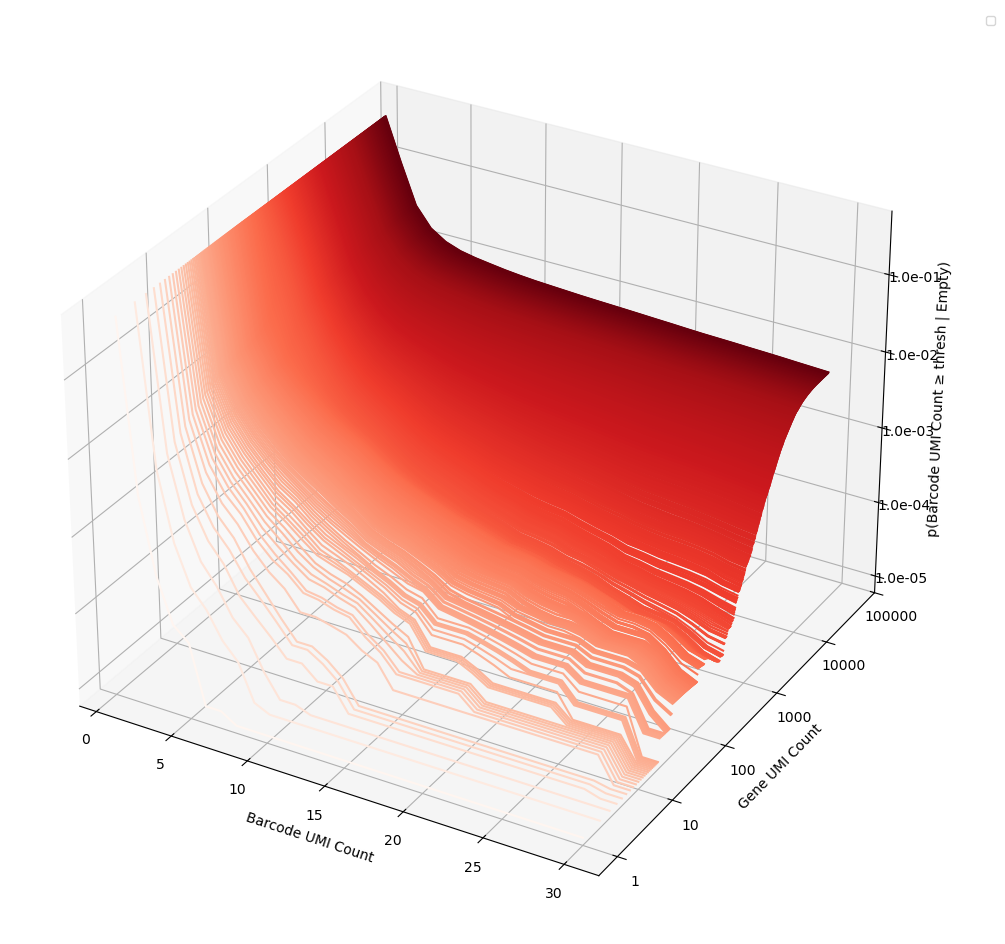

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

min_nonzero = probs_barcode_above_thresh_given_empty[probs_barcode_above_thresh_given_empty > 0].min()
probs_barcode_above_thresh_given_empty_copy = deepcopy(probs_barcode_above_thresh_given_empty)
probs_barcode_above_thresh_given_empty_copy[probs_barcode_above_thresh_given_empty_copy == 0] = min_nonzero

# Create a 3D figure
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Define the gene_umi_counts to plot
gene_umi_counts_to_plot = gene_umi_counts_to_use
guc_min = gene_umi_counts_to_plot[0]
guc_max = gene_umi_counts_to_plot[-1]

# Loop through the gene_umi_count values and plot each line in 3D
for j, gene_umi_count in enumerate(gene_umi_counts_to_plot):
    
    # Get the data for this line from Block B
    z_raw_data = probs_barcode_above_thresh_given_empty_copy[:, j]
    x_data = unique_bc_umi_counts[:max_bc_umi]#np.arange(unique_bc_umi_counts)
    
    # --- Apply Log Scales ---
    # 1. Apply log to Z-axis data (from Block B's plt.yscale('log'))
    z_data = np.log10(z_raw_data) 
    
    # 2. Apply log to Y-axis coordinate (from text request)
    y_coord = np.log10(gene_umi_count)
    y_data = [y_coord] * len(x_data)
    
    # Normalize color based on gene_umi_count (using palette from Block A)
    # Using a simple (val - min) / (max - min) normalization
    norm_color_val = (np.log10(gene_umi_count) - np.log10(guc_min)) / (np.log10(guc_max) - np.log10(guc_min))
    color = plt.cm.Reds(norm_color_val)
    
    # Plot in 3D
    ax.plot(x_data, 
            y_data, 
            z_data, 
            color=color)
            # label=f'Gene UMI Count = {gene_umi_count}')

# --- Set Labels and Ticks ---

# Set standard labels
ax.set_xlabel('Barcode UMI Count')
ax.set_ylabel('Gene UMI Count')
ax.set_zlabel('p(Barcode UMI Count ≥ thresh | Empty)')

# Fix Y-axis ticks to show linear values
# Get the current log-scale ticks
y_ticks = ax.get_yticks()
# Format them as 10^tick
y_tick_labels = [f"{10**tick:.0f}" for tick in y_ticks if 10**tick >= guc_min]
ax.set_yticks([tick for tick in y_ticks if 10**tick >= guc_min])
ax.set_yticklabels(y_tick_labels)

# Fix Z-axis ticks to show linear values
# Get the current log-scale ticks
z_ticks = ax.get_zticks()
# Format them as 10^tick in scientific notation
z_tick_labels = [f"{10**tick:.1e}" for tick in z_ticks]
ax.set_zticklabels(z_tick_labels)

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

plt.show()


In [93]:
#Easy way to get specific posterior values 
# (logspaced_gene_umi_counts doesn't have every integer, but has all up to 104, but if you want another value
# either find the closest or run with higher resolution)
# logspacing was just so the computation was faster and plot looked smoother)
probs_barcode_above_thresh_given_empty_copy[:5, np.argwhere(gene_umi_counts_to_use==10)[0][0]]
##   barcode UMI thresholds starting from >=1^^                      gene UMI threshold^^

array([0.51158695, 0.01088283, 0.00301563, 0.00146094, 0.000875  ])

In [94]:
from scipy.stats import wasserstein_distance
distances_between_adjacent_gene_umi_thresholds = []
for i in range(probs_barcode_above_thresh_given_empty_copy.shape[1]-1):
    dist = wasserstein_distance(probs_barcode_above_thresh_given_empty_copy[:, i], probs_barcode_above_thresh_given_empty_copy[:, i+1])
    distances_between_adjacent_gene_umi_thresholds.append(dist)

Text(0.5, 1.0, 'Wasserstein Distance Between Adjacent Gene UMI Count Thresholds')

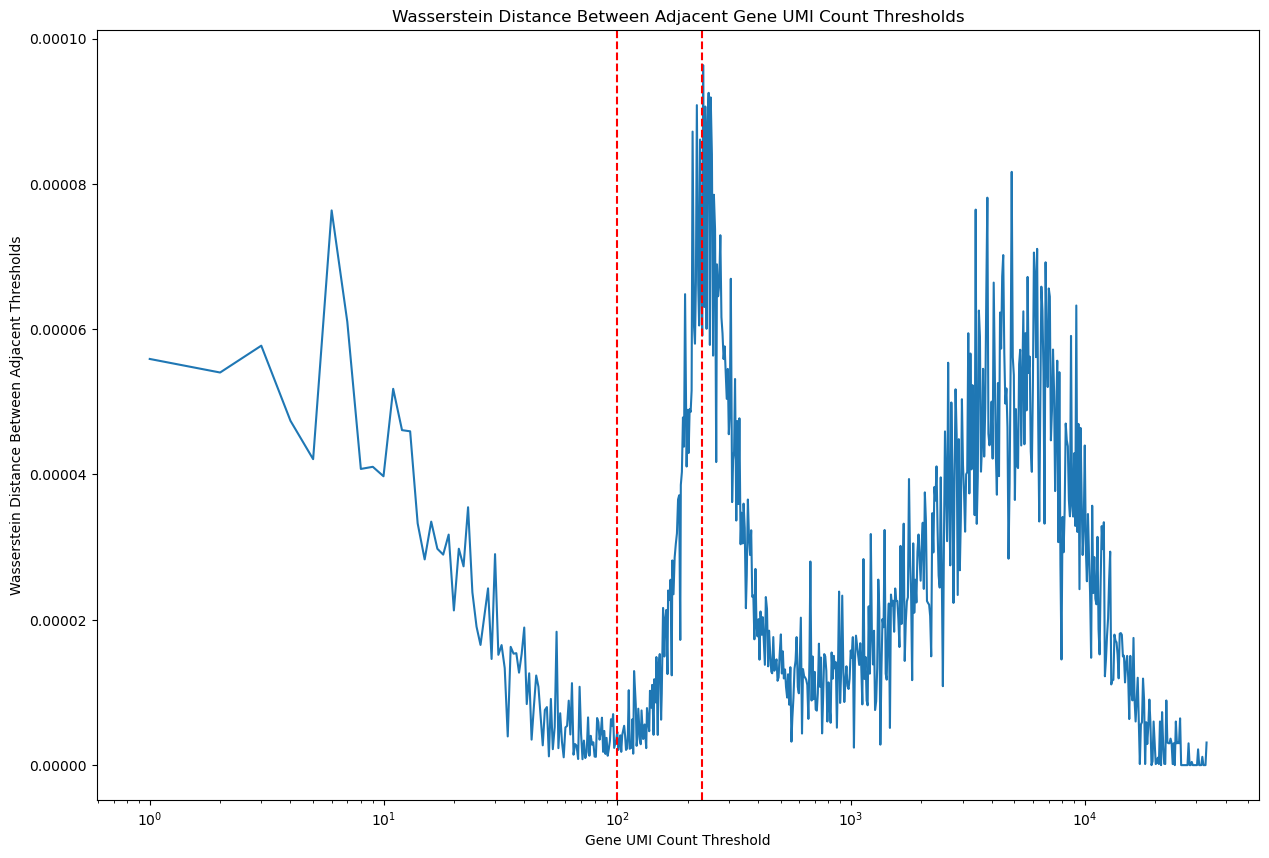

In [ ]:
#NOTE this one definitely looks cleaner using all the unique GENE UMIs
plt.figure(figsize=(15, 10))
plt.plot(gene_umi_counts_to_use[:-1], distances_between_adjacent_gene_umi_thresholds)
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=230, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Gene UMI Count Threshold')
plt.ylabel('Wasserstein Distance Between Adjacent Thresholds')
plt.title('Wasserstein Distance Between Adjacent Gene UMI Count Thresholds')

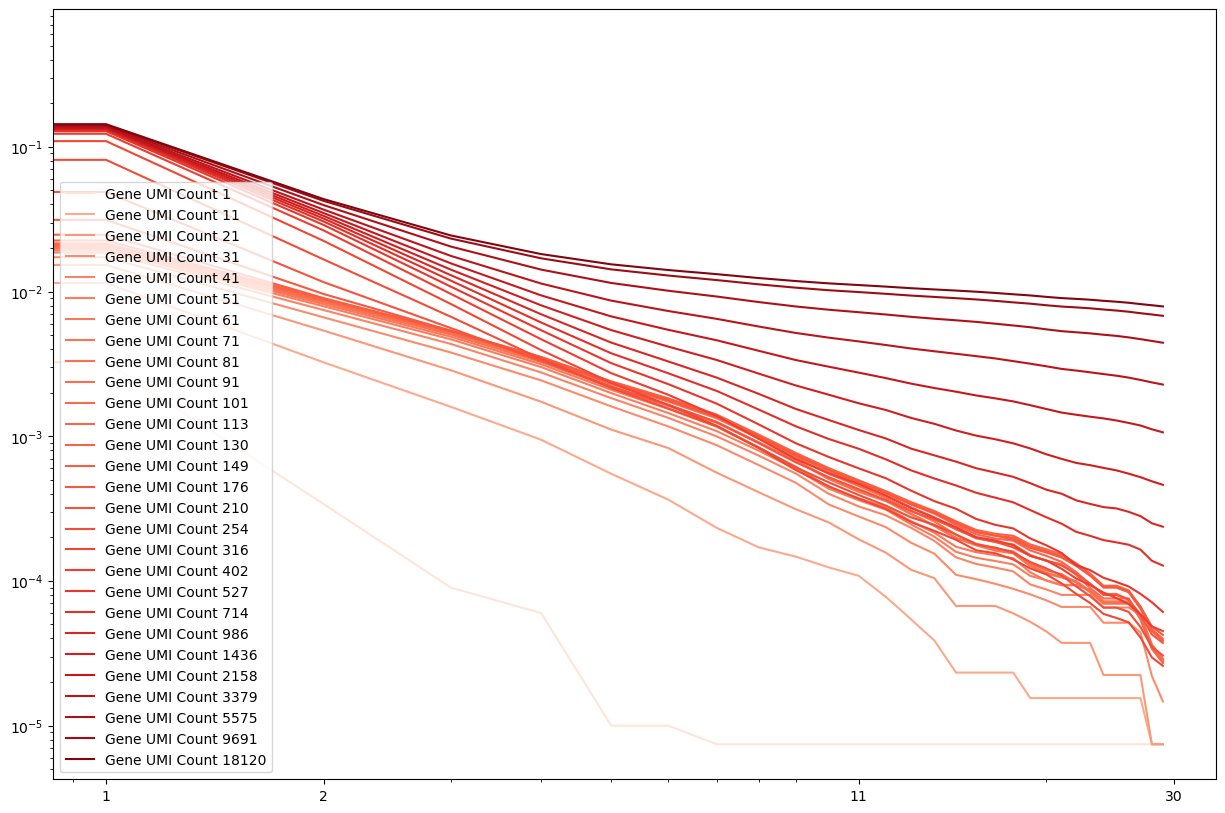

In [97]:
gene_umi_counts_subset_to_plot = gene_umi_counts_to_use#unique_gene_umi_counts[:59]
guc_min = gene_umi_counts_subset_to_plot[0]
guc_max = gene_umi_counts_subset_to_plot[-1]
plt.figure(figsize=(15, 10))
for j, gene_umi_count in enumerate(gene_umi_counts_to_use):
    if j+1 not in gene_umi_counts_to_use[::10]:
        continue
    # print(gene_umi_count)
    norm_color_val = ((np.log10(gene_umi_count) - np.log10(guc_min)) / (np.log10(guc_max) - np.log10(guc_min)))*0.9 + 0.1
    color = plt.cm.Reds(norm_color_val)
    plt.plot(probs_barcode_above_thresh_given_empty_copy[:max_bc_umi, j], color = color, label=f'Gene UMI Count {gene_umi_count}')

plt.xscale('log')
plt.yscale('log')
_ = plt.xticks(ticks = [1, 2, 11, max_bc_umi], labels = [1, 2, 11, max_bc_umi])
plt.legend()

# #Different Barcodes per droplet changes at different barcode UMI thresholds

/tmp/ipykernel_4013637/3924526434.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_per_cbc = no_g_data_non_one_umi.groupby(['CBC']).apply(lambda df: scipy.stats.entropy(df['UMI_Count'].values))
/tmp/ipykernel_4013637/3924526434.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_per_cbc = no_g_data_non_one_umi.groupby(['CBC']).apply(lambda df: scipy.stats.entropy(df['UMI_Count'].values))
/tmp/ipy

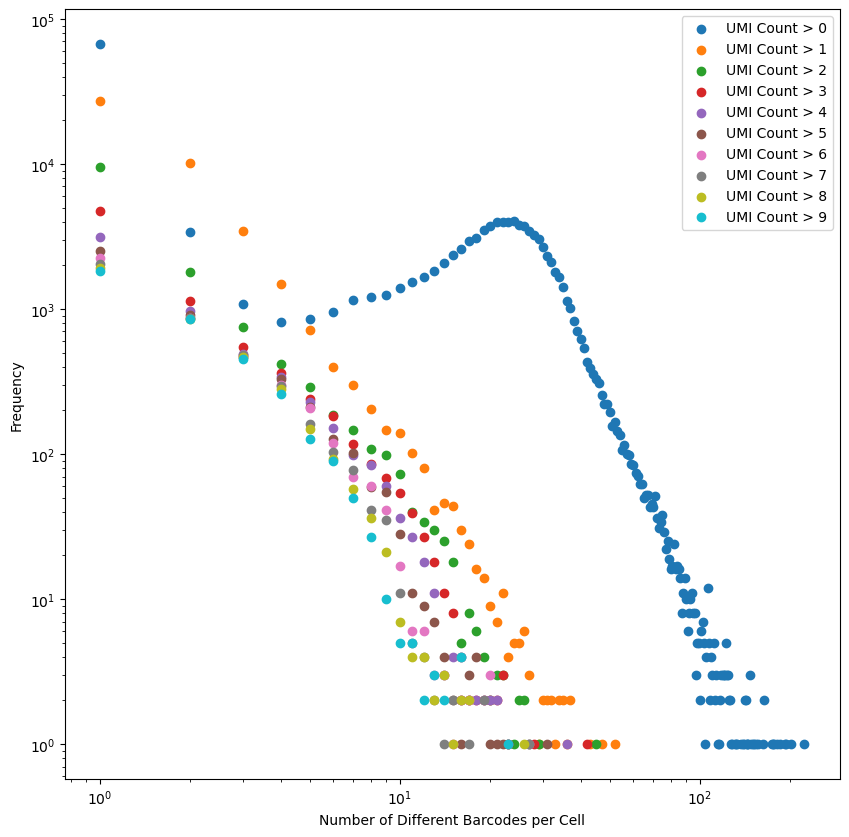

In [ ]:
# First, let's see how the number of distinct barcodes per cell changes as we filter by UMI count
# (this takes about 5 minutes but can definitely be optimized)
import scipy

plt.figure(figsize=(10,10))
cbcs_with_barcodes_with_at_least_n_umis = []
cbcs_with_barcodes_with_at_least_n_umis_masks = []
num_distinct_barcodes_per_cell_with_at_least_n_umis = []
umis_per_cell_non_one_umi_with_barcodes_with_at_least_n_umis = []
min_barcode_umi_at_least_n_umis = []
max_barcode_umi_at_least_n_umis = []
entropy_at_least_n_umis = []

for i in range(0,10):#NOTE we're looking at all barcode-containing droplets here, not just those in droplets above gene threshold
    no_g_data_non_one_umi = no_g_data[no_g_data['UMI_Count'] > i]
    barcodes_per_cell_non_one_umi = no_g_data_non_one_umi.groupby(['CBC']).count()['barcode']
    umis_per_cell_non_one_umi = no_g_data_non_one_umi.groupby(['CBC']).sum()['UMI_Count'] 
    entropy_per_cbc = no_g_data_non_one_umi.groupby(['CBC']).apply(lambda df: scipy.stats.entropy(df['UMI_Count'].values))
    entropy_at_least_n_umis.append(np.array([entropy_per_cbc.get(cbc, 0) for cbc in all_cbc_names]))

    x, y = np.unique_counts(barcodes_per_cell_non_one_umi)
    plt.scatter(x, y, label = f'UMI Count > {i}')
    cbcs_with_barcodes_with_at_least_n_umis.append(set(barcodes_per_cell_non_one_umi.index))
    cbcs_with_barcodes_with_at_least_n_umis_masks.append(np.array([cbc in cbcs_with_barcodes_with_at_least_n_umis[-1] for cbc in all_cbc_names]))
    num_distinct_barcodes_per_cell_with_at_least_n_umis.append(np.array([barcodes_per_cell_non_one_umi.get(cbc, 0) for cbc in all_cbc_names]))
    umis_per_cell_non_one_umi_with_barcodes_with_at_least_n_umis.append(np.array([umis_per_cell_non_one_umi.get(cbc, 0) for cbc in all_cbc_names]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Different Barcodes per Cell')
plt.ylabel('Frequency')
plt.legend()

In [11]:
mean_umi_per_barcode_at_least_n_umis = []
for i in range(len(umis_per_cell_non_one_umi_with_barcodes_with_at_least_n_umis)):
    mean_umi_per_barcode_at_least_n_umis.append(umis_per_cell_non_one_umi_with_barcodes_with_at_least_n_umis[i]/np.max([num_distinct_barcodes_per_cell_with_at_least_n_umis[i], np.ones_like(num_distinct_barcodes_per_cell_with_at_least_n_umis[i])], axis = 0))
    #NOTE the ones are just to avoid division by zero, but those cells will have zero UMIs anyway
mean_umi_per_barcode_at_least_n_umis = np.array(mean_umi_per_barcode_at_least_n_umis)

In [99]:
gene_umi_thresh = 100#10
empty_droplet_mask = total_gene_umis_per_cbc <= gene_umi_thresh #NOTE this includes those in NoG dataset not in full gene dataset that we assume are also empty
# empty_droplet_mask_full = total_umis_per_cbc <= gene_umi_thresh
# print(empty_droplet_mask.sum() - empty_droplet_mask_full.sum()) #Number of droplets that are empty by gene UMIs but not by total UMIs
#It's very small, so we'll keep the gene threshold as it's more standard
# all_cbc_names_with_barcodes = all_cbc_names[]

#These are all CBCs that have at least 1 barcode UMI
empty_droplet_cbcs = all_cbc_names[empty_droplet_mask & (total_barcode_umis_per_cbc > 0)]
nuclei_cbcs = all_cbc_names[~empty_droplet_mask & (total_barcode_umis_per_cbc > 0)]

In [100]:
for mask in cbcs_with_barcodes_with_at_least_n_umis_masks:
    print(f'{np.sum(np.bitwise_and(mask, ~empty_droplet_mask))} out of {np.sum(mask)} ({np.sum(np.bitwise_and(mask, ~empty_droplet_mask)) / np.sum(mask):.2%}) are above gene UMI threshold')

85147 out of 159477 (53.39%) are above gene UMI threshold
41711 out of 44747 (93.22%) are above gene UMI threshold
12347 out of 13615 (90.69%) are above gene UMI threshold
6884 out of 7648 (90.01%) are above gene UMI threshold
5199 out of 5698 (91.24%) are above gene UMI threshold
4510 out of 4847 (93.05%) are above gene UMI threshold
4171 out of 4428 (94.20%) are above gene UMI threshold
3953 out of 4150 (95.25%) are above gene UMI threshold
3759 out of 3903 (96.31%) are above gene UMI threshold
3616 out of 3723 (97.13%) are above gene UMI threshold


### And this shows us how the #Total Barcode UMIs per CBC changes after thresholding

[ 1  2  3  4  5  6  7  8  9 10] [ 209  239  347  512  702  838 1050 1143 1197 1285]
[ 2  3  4  5  6  7  8  9 10 11] [20766  2402  7251  1914  2200   902   888   487   393   280]
[ 3  4  5  6  7  8  9 10 11 12] [5108 1372  508  576  342  235  205  141  108   83]
[ 4  5  6  7  8  9 10 11 12 13] [1641  612  276  163  195  159   98   81   72   78]
[ 5  6  7  8  9 10 11 12 13 14] [679 308 188 149 114  90  75  65  78  37]
[ 6  7  8  9 10 11 12 13 14 15] [334 206 174 121  76  58  57  60  38  40]
[ 7  8  9 10 11 12 13 14 15 16] [224 188 129  81  61  56  50  27  35  43]
[ 8  9 10 11 12 13 14 15 16 17] [198 137  84  64  62  53  31  29  37  38]
[ 9 10 11 12 13 14 15 16 17 18] [146  93  74  67  58  34  31  35  33  26]
[10 11 12 13 14 15 16 17 18 19] [103  78  70  59  41  34  37  35  28  29]


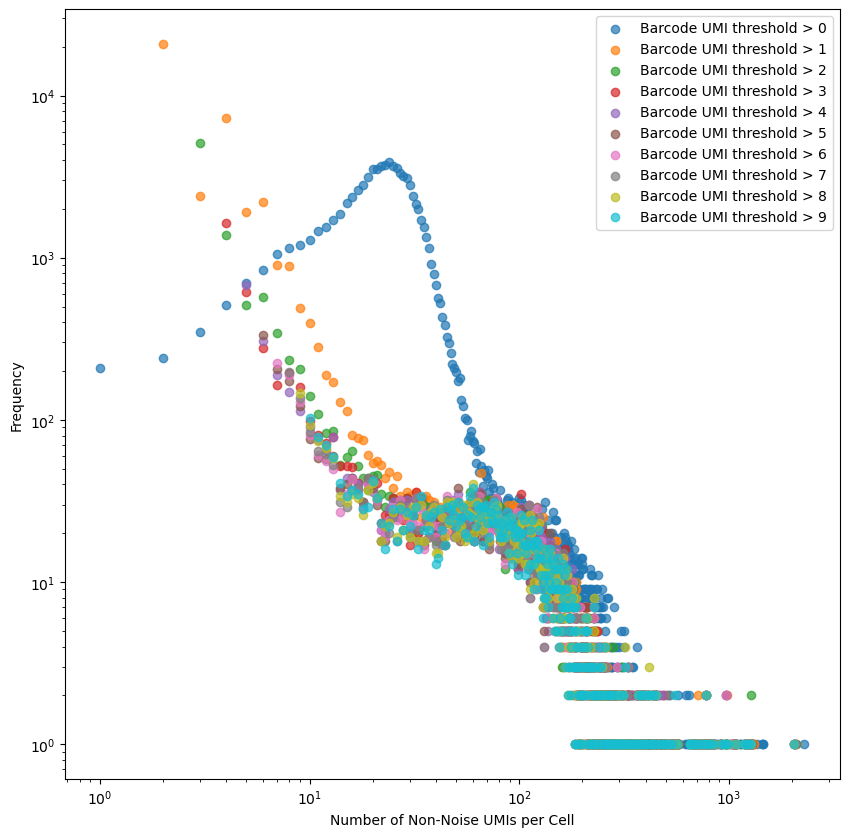

In [98]:
plt.figure(figsize=(10,10))
for i, mask in enumerate(cbcs_with_barcodes_with_at_least_n_umis_masks):
    # if i == 5:
    #     break
    num_non_noise_umis_per_droplet = (umis_per_cell_non_one_umi_with_barcodes_with_at_least_n_umis[i])[np.bitwise_and(~empty_droplet_mask, mask)]
    x, y = np.unique_counts(num_non_noise_umis_per_droplet)
    print(x[:10], y[:10])
    plt.scatter(x, y, label = f'Barcode UMI threshold > {i}', alpha = 0.7)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Non-Noise UMIs per Cell')
plt.ylabel('Frequency')
plt.legend()